# Attrition Predict Using Neural Networks

## Problem Statement   
A large company named АВС, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons
1. The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
1. A sizeable department has to be maintained, for the purposes of recruiting new talent
1. More often than not, the new employees have to be trained for the job and/or given time to acclimatise themselves to the company


In [ ]:
import os
import numpy as np
import pandas as pd


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read Data

In [ ]:
in_time = pd.read_csv('/kaggle/input/hr-analytics-case-study/in_time.csv')
manager_survey_data = pd.read_csv('/kaggle/input/hr-analytics-case-study/manager_survey_data.csv')
employee_survey_data = pd.read_csv('/kaggle/input/hr-analytics-case-study/employee_survey_data.csv')
out_time = pd.read_csv('/kaggle/input/hr-analytics-case-study/out_time.csv')
general_data = pd.read_csv('/kaggle/input/hr-analytics-case-study/general_data.csv')

Dealing with clock-in/clock-out

In [ ]:
in_time = in_time.fillna(0)
in_time.iloc[:, 1:] = in_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
out_time = out_time.fillna(0)
out_time.iloc[:, 1:] = out_time.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
in_time = in_time.append(out_time)
in_time=in_time.diff(periods=4410) 
in_time=in_time.iloc[4410:]
in_time.reset_index(inplace=True)
in_time.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)
in_time.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True) 
in_time['Actual Time']=in_time.mean(axis=1) 
in_time['hrs']=in_time['Actual Time']/np.timedelta64(1, 'h')
in_time.reset_index(inplace=True)
in_time.drop(in_time.columns.difference(['index','hrs']), 1, inplace=True)
in_time.rename(columns={'index': 'EmployeeID'},inplace=True)
print(in_time.shape)

In [ ]:
in_time

In [ ]:
df_2 = pd.read_csv('/kaggle/input/hr-analytics-case-study/employee_survey_data.csv')
print(df_2.columns)
print(df_2.shape)
df_2

# Concatenation main DF and Social Metrics DF

In [ ]:
df =  pd.concat([df.set_index('EmployeeID'), df_1.set_index('EmployeeID'),df_2.set_index('EmployeeID')], axis=1, join='inner').reset_index()
df

# Research of DateTime frames and data extraction

In [ ]:
weekends = ['2015-12-25', '2015-10-02', '2015-11-11', '2015-05-01',
            '2015-01-14', '2015-11-10', '2015-03-05', '2015-07-17',
            '2015-01-26', '2015-11-09', '2015-09-17', '2015-01-01']

In [ ]:
df_in = pd.read_csv('/kaggle/input/hr-analytics-case-study/in_time.csv')
df_in.iloc[:,1:] = df_in.iloc[:,1:].astype('datetime64[ns]')
df_in.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
df_in.drop(weekends, axis=1, inplace=True)
# for col in df_in.columns[1:]:
#     df_in[col] = pd.to_datetime(df_in[col]).dt.time
print(df_in.shape)
df_in[:2]

In [ ]:
df_in_hour = pd.DataFrame()
for col in df_in.columns[1:]:
    time = pd.DatetimeIndex(df_in[col])
    df_in_hour[col] = (time.hour * 60 + time.minute)/60

df_in_hour[:2]

In [ ]:
df_out = pd.read_csv('/kaggle/input/hr-analytics-case-study/out_time.csv')
df_out.iloc[:,1:] = df_out.iloc[:,1:].astype('datetime64[ns]')
df_out.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
df_out.drop(weekends, axis=1, inplace=True)
# for col in df_out.columns[1:]:
#     df_out[col] = pd.to_datetime(df_out[col]).dt.time
print(df_out.shape)
df_out[:2]

In [ ]:
df_out_hour = pd.DataFrame()
for col in df_out.columns[1:]:
    time = pd.DatetimeIndex(df_out[col])
    df_out_hour[col] = (time.hour * 60 + time.minute)/60

df_out_hour[:2]

# Create DF for time parameters (later concat)

### !!! Let's chek inexes from data frames with time

In [ ]:
time_df = pd.DataFrame()
time_df['EmployeeID_in'] = df_in['EmployeeID']
time_df['EmployeeID_out'] = df_out['EmployeeID']
time_df['EmployeeID'] = time_df['EmployeeID_in'] - time_df['EmployeeID_out']
not_zero = time_df.loc[time_df['EmployeeID'] != 0]
time_df['EmployeeID'] = df_in['EmployeeID']
not_zero

In [ ]:
time_df.drop(['EmployeeID_in','EmployeeID_out'], axis=1, inplace=True)
time_df[:2]

In [ ]:
df_in_avg = pd.DataFrame()
time_df['in_avg'] = df_in_hour.iloc[:,1:].mean(axis=1)
time_df[:2]

In [ ]:
df_out_avg = pd.DataFrame()
time_df['out_avg'] = df_out_hour.iloc[:,1:].mean(axis=1)
time_df[:2]

In [ ]:
df_out_avg = pd.DataFrame()
time_df['avg_work_day'] = time_df['out_avg'] - time_df['in_avg']
time_df[:2]

In [ ]:
time_df['num_day_off'] = df_in_hour.isnull().sum(axis=1)
time_df[:2]

# Concatenation main DF and time parameters DF

In [ ]:
df =  pd.concat([df.set_index('EmployeeID'), time_df.set_index('EmployeeID')], axis=1, join='inner').reset_index()
df.reset_index(drop=True, inplace=True)
df

# Data cleaning

### Drop useless columns

In [ ]:
for el in list(df.columns):
    print(f'======================= {el} =======================')
    print(df[el].value_counts(dropna=False))
    print('')

In [ ]:
# to drop
# 'EmployeeCount', 'Over18', 'StandardHours'
df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)




In [ ]:
df.info()

# NaN cleaning

In [ ]:
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
        null_view = pd.DataFrame(null_view, columns=['NANs'])
        null_view[['PERCENT']] = null_view.NANs.apply(lambda x: round((x/len(df))*100, 2))
        null_view[['TYPE']] = df.dtypes
    except:
        return null_view
    return null_view

NaN_info(df)

In [ ]:
all_nan = list(null_view[-12:].index)
all_nan

In [ ]:
indexes = df.loc[pd.isnull(df[['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance']]).any(1), :].index.values
print(f'Number indexes with missing data: {len(indexes)}')
print(indexes)

In [ ]:
df = df.drop(df.index[indexes])
time_df = time_df.drop(time_df.index[indexes])
df.reset_index(drop=True, inplace=True)
time_df.reset_index(drop=True, inplace=True)
print(df.shape)
print(time_df.shape)

# NaN ML imputation

In [ ]:
def nan_predict(df,
                skip_features_from_prediction_where_percent_missing_data_more_than = 100,
                include_features_as_predictors_where_perc_missing_data_less_than = 50,
                apply_fast_predictor_where_missing_data_less_than_percent = 100,
                use_n_rows_for_train_not_more_than = 1000000000,    #  If your dataframe is large
                randomizedSearchCV_iter_plus_perc_missing_data = 10,
                n_estimators_parameter_for_LightGBM = 2000,
                target_feature = None,   # For prediction at the end
                ): 
    
    import random
    import pandas as pd
    import numpy as np

    # Disabling warnings
    import sys
    import warnings
    if not sys.warnoptions:
        warnings.simplefilter("ignore")


    from lightgbm import LGBMClassifier
    from lightgbm import LGBMRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    from sklearn.preprocessing import LabelEncoder
    
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    

    global counter_all_predicted_values
    counter_all_predicted_values = 0
    
    global numeric_features
    numeric_features = []
    
    global best_params
    
    
    PARAMS  =  {'num_leaves': [12, 50, 120, 200, 300, 400, 500],   #np.arange(200, 600, step=100),
                'max_depth': [4, 8, 12, 16],
                'learning_rate': [0.001, 0.01, 0.1],
                'n_estimators': [n_estimators_parameter_for_LightGBM],
                'subsample': [0.1, 0.3, 0.5],
                'feature_fraction': [0.1, 0.3, 0.5],
                'bagging_fraction': [0.1, 0.3, 0.5],
                'bagging_seed': np.arange(1, 3, step=1),
                'lambda_l1': [0.2],
                'lambda_l2': [0.1],
                'min_child_samples': np.arange(2, 6, step=2),
                'min_split_gain': [0.0001, 0.001]
               }
    
    
    CV = ShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
    
    
    

    def NaN_info(df):
        global null_view
        try:
            null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
            null_view = pd.DataFrame(null_view, columns=['NANs'])
            null_view[['PERCENT']] = null_view.NANs.apply(lambda x: round((x/len(df))*100, 2))
            null_view[['TYPE']] = df.dtypes
        except:
            return null_view
        return null_view
    
    
    def numeric_features(df):
        num_features = [feature for feature in df.columns if df[feature].dtype in ['int64', 'float64']]
        return num_features
    
    
    def integer_features(df):
        global int_features
        int_features = [feature for feature in df.columns if df[feature].dtype in ['int64']]
        return int_features


    def encoding(work_predictors, df):
        feature_power = 0.5          # Skew handling
        for j in work_predictors:
            el_type = df[j].dtype
            if el_type == 'object':
                df[j].replace(np.nan, 'NoNoNo', inplace=True)
                labelencoder = LabelEncoder()
                df.loc[:, j] = labelencoder.fit_transform(df.loc[:, j])
            else:
                df[j] = df[j]**feature_power
        return df, work_predictors


    def hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg, scoring):
        global best_params
        global pred_test_lgb

        lgbm = alg(random_state = 0)
        lgbm_randomized = RandomizedSearchCV(estimator=lgbm, 
                                            param_distributions=PARAMS, 
                                            n_iter=n_iter_for_RandomizedSearchCV, 
                                            scoring=scoring, 
                                            cv=CV, 
                                            verbose=0,
                                            n_jobs = -1)

        lgbm_randomized.fit(X_train, y_train)
        
        best_params = lgbm_randomized.best_params_
        pred_test_lgb = lgbm_randomized.predict(X_test)
        return best_params, pred_test_lgb

    
    def predict_regressor(best_params, X, y, miss_df):
        print('Best parameters:')
        print(best_params)
        print('')
        global pred_miss
        lgbm = LGBMRegressor(**best_params, n_jobs=-1, random_state=0)
        lgbm = lgbm.fit(X, y)
        pred_miss = list(lgbm.predict(miss_df))
        print('-------------------------------')
        print(f"The first 100 predicted missing values: \n{pred_miss[:100]}")
        return pred_miss


    def predict_classifier(best_params, X, y, miss_df):
        print('Best parameters:')
        print(best_params)
        print('')
        global pred_miss
        lgbm = LGBMClassifier(**best_params, n_jobs=-1, random_state=0)
        lgbm = lgbm.fit(X, y)
        pred_miss = list(lgbm.predict(miss_df))
        print('-------------------------------')
        print(f"The first 100 predicted missing values: \n{pred_miss[:100]}")
        return pred_miss
    
    
    def imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el):
        counter = 0
        for idx in miss_indeces:
            df.loc[idx, el] = pred_miss[counter]
            counter += 1
        return df
    
    
    
    # Go)

    plt.figure(figsize=(20, 5))
    sns.heatmap(df.isnull(), cbar=False)
    
    
    print(NaN_info(df))
    print('\n\n\n')
    
    all_features = list(df.columns)
    df_indeces = list(df.index)
    df.reset_index(drop=True, inplace=True)
    
    integer_features(df)

    delete_miss_features = list(
        (null_view.loc[null_view['PERCENT'] > skip_features_from_prediction_where_percent_missing_data_more_than]).index)
    print(f'Exclude from the prediction, because missing data more than \
    {skip_features_from_prediction_where_percent_missing_data_more_than}% :\n{delete_miss_features}')
    print('')
    all_miss_features = list(null_view.index)

    for delete_feature in delete_miss_features:
        all_miss_features.remove(delete_feature)
        
    
    if target_feature in all_miss_features:  # moving target_feature to end of the prediction
        all_miss_features.append(all_miss_features.pop(all_miss_features.index(target_feature)))
        
    
    for el in all_miss_features:
        print('\n\n\n\n')
        
        # select features as predictors
        NaN_info(df)
        lot_of_miss_features = list(
            (null_view.loc[null_view['PERCENT'] > include_features_as_predictors_where_perc_missing_data_less_than]).index)
        now_predictors = list(set(all_features)-set(lot_of_miss_features))
        work_predictors = list(set(now_predictors) - set([el]))

        
        # missing data (data for prediction)
        miss_indeces = list((df[pd.isnull(df[el])]).index)
        miss_df = df.iloc[miss_indeces][:]
        miss_df = miss_df[work_predictors]
        encoding(work_predictors, df=miss_df)

        
        # data without NaN rows (X data for train, evaluation of model)
        work_indeces = list(set(df_indeces) - set(miss_indeces))
        if len(work_indeces) > use_n_rows_for_train_not_more_than:
            randomlist = random.sample(range(0, len(work_indeces)), use_n_rows_for_train_not_more_than)
            work_indeces = [work_indeces[i] for i in randomlist]
        
        work_df = df.iloc[work_indeces][:] 
        encoding(work_predictors, df=work_df)
        X = work_df[work_predictors]
        y = work_df[el]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

        
        # Info
        feature_type = df[el].dtypes
        percent_missing_data = null_view['PERCENT'][el]
        print(f'Feature: {el},   type: {feature_type},   missing values: {percent_missing_data}%\n')    
        print(f'Shape for train dataframe: {(X.shape)}')
        print(f'Unused features as predictors, because missing data more than {include_features_as_predictors_where_perc_missing_data_less_than}% :')
        print(lot_of_miss_features)
        print('')
        
        
        # PREDICTIONS
        if percent_missing_data < apply_fast_predictor_where_missing_data_less_than_percent:
            
            # FAST Predictions without tuning hyperparameters
            
            print('FAST prediction without tuning hyperparameters\n')
            best_params = {}
            if feature_type == 'object' or feature_type == 'bool':
                print('FAST CLASSIFIER:')
                labelencoder = LabelEncoder()
                y_train = labelencoder.fit_transform(y_train)
                y_test = labelencoder.fit_transform(y_test)
                lgbm = LGBMClassifier(n_jobs=-1, random_state=0)
                lgbm = lgbm.fit(X_train, y_train)
                pred_test_lgb_FAST = lgbm.predict(X_test)
                accuracy = accuracy_score(y_test, pred_test_lgb_FAST)
                print('Evaluations:')
                print(f'first 10 y_test: {y_test[:10]}')
                print(f'first 10 y_pred: {pred_test_lgb_FAST[:10]}\n')
                f1 = f1_score(y_test, pred_test_lgb_FAST, average='weighted')
                print(f'accuracy_score:      {accuracy}')
                print(f'f1_score (weighted): {f1}')
                
                predict_classifier(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            elif feature_type == 'float64' or feature_type == 'int64':
                print('FAST REGRESSOR:')
                
                lgbm = LGBMRegressor(n_jobs=-1, random_state=0)
                lgbm = lgbm.fit(X_train, np.log1p(y_train))
                pred_test_lgb_FAST = lgbm.predict(X_test)
                pred_test_lgb_FAST = np.expm1(pred_test_lgb_FAST)
                MAE = mean_absolute_error(y_test,pred_test_lgb_FAST)
                y_te = list(round(y_test[:10], 1))
                y_pred = list(np.round(pred_test_lgb_FAST[:10], 1))
                print('Evaluations:')
                print(f'first 10 y_test: {y_te}')
                print(f'first 10 y_pred: {y_pred}\n')
                print(f'mean_absolute_error: {MAE}')
                print(f'mean for {el}: {df[el].mean()}')
                
                predict_regressor(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            else:
                print(f"unprocessed feature: {el} - {feature_type} type")
                
                  
        else:
            
            # ADVANCED Predictions with tuning hyperparameters
            
            n_iter_for_RandomizedSearchCV = int(randomizedSearchCV_iter_plus_perc_missing_data + percent_missing_data * 1)
            print(f'Iteration for RandomizedSearchCV: {n_iter_for_RandomizedSearchCV}\n')
            
            if feature_type == 'object' or feature_type == 'bool':
                print('ADVANCED CLASSIFIER:')
                labelencoder = LabelEncoder()
                y_train = labelencoder.fit_transform(y_train)
                y_test = labelencoder.fit_transform(y_test)
                hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg=LGBMClassifier, scoring='f1_weighted')
                accuracy = accuracy_score(y_test, pred_test_lgb)
                print('Evaluations:')
                print(f'first 10 y_test: {y_test[:10]}')
                print(f'first 10 y_pred: {pred_test_lgb[:10]}\n')
                f1 = f1_score(y_test, pred_test_lgb, average='weighted')
                print(f'accuracy_score:      {accuracy}')
                print(f'f1_score (weighted): {f1}')
                
                predict_classifier(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            elif feature_type == 'float64' or feature_type == 'int64':
                print('ADVANCED REGRESSOR:')
                hyperparms_tuning(CV, X_train, X_test, y_train, y_test, n_iter_for_RandomizedSearchCV, PARAMS, alg=LGBMRegressor, scoring='neg_mean_squared_error')
                MAE = mean_absolute_error(y_test,pred_test_lgb)
                y_te = list(round(y_test[:10], 1))
                y_pred = list(np.round(pred_test_lgb[:10], 1))
                print('Evaluations:')
                print(f'first 10 y_test: {y_te}')
                print(f'first 10 y_pred: {y_pred}\n')
                print(f'mean_absolute_error: {MAE}')
                print(f'mean for {el}: {df[el].mean()}')
                
                predict_regressor(best_params, X, y, miss_df)
                counter_all_predicted_values += len(miss_indeces)
                imput_missing_value_to_main_df(df, miss_indeces, pred_miss, el)

            else:
                print(f"unprocessed feature: {el} - {feature_type} type")
        
        plt.figure(figsize=(20, 5))
        sns.heatmap(df.isnull(), cbar=False)

        
    for feature in int_features:
        df[[feature]] = df[[feature]].astype('int64')
        
    df.index = df_indeces

    print('\n\n\n')
    print(f'These features have not been processed, because missing data more than {skip_features_from_prediction_where_percent_missing_data_more_than}%')
    print(NaN_info(df))
    print('\n\n\n')
    print(f'{counter_all_predicted_values} values have been predicted and replaced')
    print('\n')
    
    return df

In [ ]:
nan_predict(df)

# To int

In [ ]:
integer  = ['TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 
            'WorkLifeBalance', 'NumCompaniesWorked']
for col in integer:
    df[[col]] = df[[col]].astype('int64')


In [ ]:
for el in list(df.columns):
    print(f'======================= {el} =======================')
    print(df[el].value_counts(dropna=False))
    print('')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set(font_scale=1.5)
sns.set_style(style='white') 

time_df[['Attrition']] = df[['Attrition']]

for el in time_df.columns:
    plot_data = time_df[['Attrition', el]]
    try:
        g = sns.pairplot(plot_data, hue='Attrition', palette='Set1', height=10, aspect=2)
        
        handles = g._legend_data.values()
        labels = g._legend_data.keys()
        g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
    except:
        pass

In [ ]:
def categorical_features(df):
    global cat_features
    cat_features = [feature for feature in df.columns if df[feature].dtype in ['object']]
    return cat_features

categorical_features(df)

In [ ]:
# sns.set_palette('twilight_shifted')
for el in cat_features:
    plot_data = df[['Attrition', el]]
    try:
        plt.figure(figsize=(20,10))
        sns.countplot(x=plot_data[el], hue='Attrition', data=plot_data, palette='winter_r')
    except:
        pass

In [ ]:
print('Impact of Performance Rating')
print('\n\n')

print('PerformanceRating == 4 (The Highest)')
print('')
a = df.loc[(df['Attrition'] == 'Yes') & (df['PerformanceRating'] == 4)]
print(f'Number of Dismissed: \t\t\t{len(a)}')
print(f'Average Age: \t\t\t\t{a.Age.mean()}')
print(f'Average Monthly Income: \t\t{a.MonthlyIncome.mean()}')
print(f'Average Years at Company: \t\t{a.YearsAtCompany.mean()}')
print(f'Average Years with Current Manager:\t{a.YearsWithCurrManager.mean()}')
print('\n\n')


print('PerformanceRating == 3 (The lowest)')
print('')
b = df.loc[(df['Attrition'] == 'Yes') & (df['PerformanceRating'] == 3)]
print(f'Number of Dismissed: \t\t\t{len(b)}')
print(f'Average Age: \t\t\t\t{b.Age.mean()}')
print(f'Average Monthly Income: \t\t{b.MonthlyIncome.mean()}')
print(f'Average Years at Company: \t\t{b.YearsAtCompany.mean()}')
print(f'Average Years with Current Manager:\t{b.YearsWithCurrManager.mean()}')

In [ ]:
print('Dismissals with Performance Rating and overtime (avg_work_day >= 10)')
print('\n\n')

print('PerformanceRating == 4 (The Highest)')
print('')
a = df.loc[(df['Attrition'] == 'Yes') & (df['avg_work_day'] >= 10) & (df['PerformanceRating'] == 4)]
print(f'Number of Dismissed: \t\t\t{len(a)}')
print(f'Average Age: \t\t\t\t{a.Age.mean()}')
print(f'Average Monthly Income: \t\t{a.MonthlyIncome.mean()}')
print(f'Average Years at Company: \t\t{a.YearsAtCompany.mean()}')
print(f'Average Years with Current Manager:\t{a.YearsWithCurrManager.mean()}')
print('\n\n')


print('PerformanceRating == 3 (The lowest)')
print('')
b = df.loc[(df['Attrition'] == 'Yes') & (df['avg_work_day'] >= 10) & (df['PerformanceRating'] == 3)]
print(f'Number of Dismissed: \t\t\t{len(b)}')
print(f'Average Age: \t\t\t\t{b.Age.mean()}')
print(f'Average Monthly Income: \t\t{b.MonthlyIncome.mean()}')
print(f'Average Years at Company: \t\t{b.YearsAtCompany.mean()}')
print(f'Average Years with Current Manager:\t{b.YearsWithCurrManager.mean()}')

# Encoding

In [ ]:
categorical_features(df)

In [ ]:
for el in categorical_features(df):
    print(f'======================= {el} =======================')
    print(df[el].value_counts(dropna=False))
    print('')

In [ ]:
change = {
    'No': 0,
    'Yes': 1
}

df['Attrition'] = df['Attrition'].map(change)
df['Attrition'] = df['Attrition'].astype('int64')
df['Attrition'].unique()

In [ ]:
change = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}

df['BusinessTravel'] = df['BusinessTravel'].map(change)
df['BusinessTravel'] = df['BusinessTravel'].astype('int64')
df['BusinessTravel'].unique()

In [ ]:
# change = {
#     'Research & Development': 0,
#     'Sales': 1,
#     'Human Resources': 2
# }

# df['Department'] = df['Department'].map(change)
# df['Department'] = df['Department'].astype('int64')
# df['Department'].unique()


dum_df = pd.get_dummies(df, columns=['Department'])
df =pd.concat([dum_df])
df[:2]

In [ ]:
change = {
    'Other': 0,
    'Life Sciences': 1,
    'Medical': 2,
    'Marketing': 3,
    'Technical Degree': 4,
    'Human Resources': 5,
}

df['EducationField'] = df['EducationField'].map(change)
df['EducationField'] = df['EducationField'].astype('int64')
df['EducationField'].unique()

In [ ]:
# change = {
#     'Sales Executive': 0,
#     'Research Scientist': 1,
#     'Laboratory Technician': 2,
#     'Manufacturing Director': 3,
#     'Healthcare Representative': 4,
#     'Manager': 5,
#     'Sales Representative': 6,
#     'Research Director': 7,
#     'Human Resources': 8,
# }


# df['JobRole'] = df['JobRole'].map(change)
# df['JobRole'] = df['JobRole'].astype('int64')
# df['JobRole'].unique()


dum_df = pd.get_dummies(df, columns=['JobRole'])
df =pd.concat([dum_df])
df[:2]

In [ ]:
change = {
    'Male': 0,
    'Female': 1,
}

df['Gender'] = df['Gender'].map(change)
df['Gender'] = df['Gender'].astype('int64')
df['Gender'].unique()

In [ ]:
change = {
    'Single': 0,
    'Divorced': 1,
    'Married': 2
}

df['MaritalStatus'] = df['MaritalStatus'].map(change)
df['MaritalStatus'] = df['MaritalStatus'].astype('int64')
df['MaritalStatus'].unique()

In [ ]:
desc = pd.DataFrame()
a = list(df.columns)
for el in a:
    uniq = df[el].unique()
    desc.loc[el, "values"] = str(uniq)

desc

In [ ]:
general_dism = df.loc[df['Attrition'] == 1]
undesirable_dism = df.loc[(df['Attrition'] == 1) & (df['JobInvolvement'] >= 3) & (df['PerformanceRating'] == 4)]

for col in df.columns:
    plt.figure(figsize=(10, 5))
    plt.title(col)
    plt.scatter(general_dism.index, general_dism[col], label="general dismissed", color='blue')
    plt.scatter(undesirable_dism.index, undesirable_dism[col], label="undesirable dismissed", color='red')
    plt.legend()
    plt.show()

# Drop duplicate data => target leakage

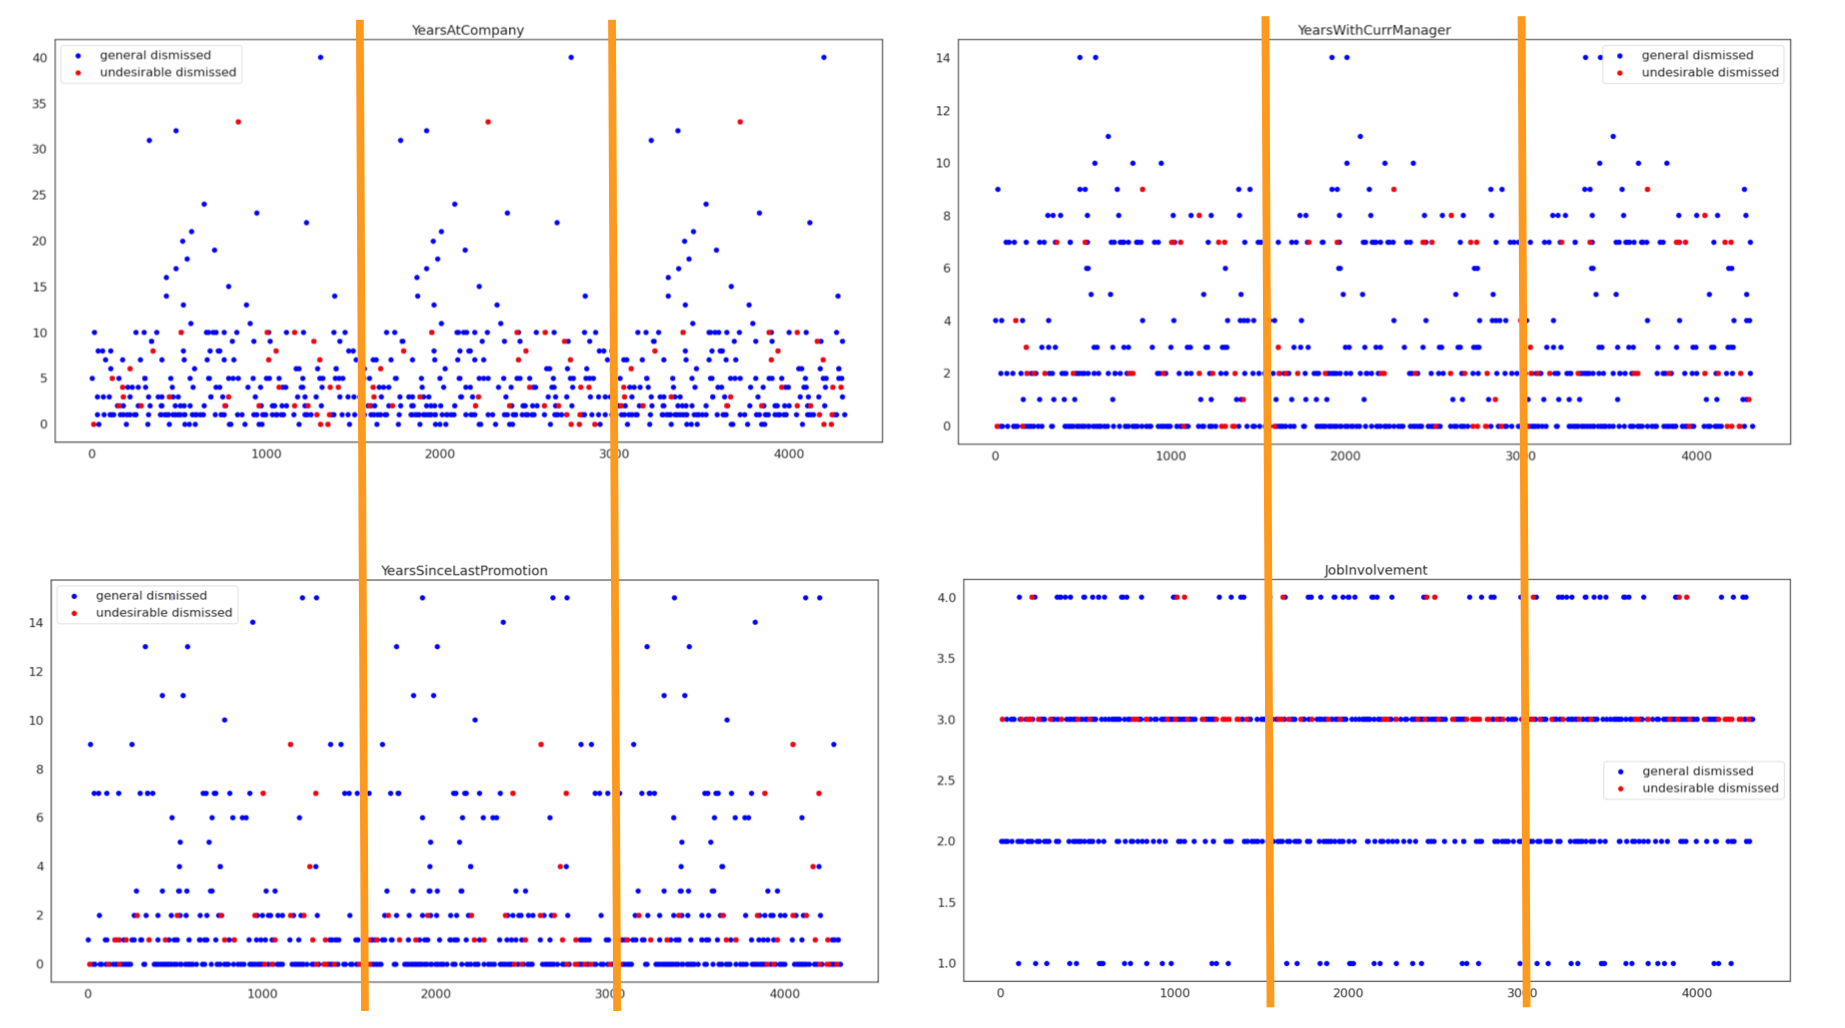

In [ ]:
df = df[:1600]

# Statistic

In [ ]:
still_working = df.loc[df['Attrition'] == 0]
general_dism = df.loc[df['Attrition'] == 1]
undesirable_dism = df.loc[(df['Attrition'] == 1) & (df['JobInvolvement'] >= 3) & (df['PerformanceRating'] == 4)]


print('                                                company         still working       general dismissed   undesirable dismissed\n')
print(f'Number                                           {df.shape[0]}                 {still_working.shape[0]}                  {general_dism.shape[0]}                   {undesirable_dism.shape[0]}\n')

for col in df.columns:
    comp = round(df[col].mean(), 2)
    still = round(still_working[col].mean(), 2)
    gen = round(general_dism[col].mean(), 2)
    undes = round(undesirable_dism[col].mean(),2)
    print("{:35s} {:20.2f} {:20.2f} {:20.2f} {:20.2f} ".format(col, comp, still, gen, undes))

## EDA for Managers
'PerformanceRating', 'JobSatisfaction', 'JobInvolvement',     
'EnvironmentSatisfaction', 'Attrition'(Dismissals), 'YearsAtCompany',     

## EDA for employees
'MonthlyIncome', 'StockOptionLevel', 'PercentSalaryHike', 'YearsWithCurrManager',    
'Education', 'WorkLifeBalance', 'MaritalStatus',  'JobLevel', 'DistanceFromHome',     
'TotalWorkingYears', 'TrainingTimesLastYear', 'BusinessTravel',    
'EducationField', 'NumCompaniesWorked',  'YearsSinceLastPromotion',    
'avg_work_day', 'num_day_off', 


## EDA for fun))   
'in_avg', 'out_avg', 'Age', 'Gender', 'EmployeeID'

# ML Research

In [ ]:
import shap
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split


features = [
    # EDA for Managers
    'PerformanceRating', 'JobSatisfaction', 'JobInvolvement',
    'EnvironmentSatisfaction', 'Attrition', 'YearsAtCompany',
    
    # EDA for employees
    'MonthlyIncome', 'StockOptionLevel', 'PercentSalaryHike', 'YearsWithCurrManager',
    'Education', 'WorkLifeBalance', 'MaritalStatus', 'JobLevel', 'DistanceFromHome',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'BusinessTravel',
    'EducationField', 'NumCompaniesWorked', 'YearsSinceLastPromotion',
    'avg_work_day', 'num_day_off',

    # EDA for fun
    'in_avg', 'out_avg', 'Age', 'Gender', 'EmployeeID'
    ]


for col in features[:]:
    df_research = df.copy()

    target = [col]
    predictors = list(set(list(df_research.columns)) - set(target))

    X = df_research[predictors]
    y = df_research[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    print(f'{target}')
    model = LGBMRegressor(random_state=0).fit(X_train, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    

    plt.title(col)
    plt.gcf().subplots_adjust()
    shap.summary_plot(shap_values, X_test, max_display=X.shape[1], show=True, plot_size=(10, 12))
    plt.savefig("shap_"+col+"_.png")
    plt.close()

# Undesirable dismissions

In [ ]:
print(df['JobInvolvement'].unique())
print(df['PerformanceRating'].unique())

In [ ]:
undesirable = df.loc[(df['JobInvolvement'] >= 3) & (df['PerformanceRating'] == 4)]
undesirable

In [ ]:
df_research = undesirable.copy()

target = ['Attrition']
predictors = list(set(list(df_research.columns)) - set(target))

X = df_research[predictors]
y = df_research[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(f'{target}')
model = LGBMRegressor(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


plt.title('Attrition')
plt.gcf().subplots_adjust()

shap.summary_plot(shap_values, X_test, max_display=X.shape[1], show=True, plot_size=(10, 12))




plt.savefig("shap_"+col+"_.png")
plt.close()

# Deep understanding with PDP Plots

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp
from lightgbm import LGBMRegressor


df_permutation_1 = df.copy()

features = [
    'PerformanceRating', 'JobSatisfaction', 'JobInvolvement',
    'EnvironmentSatisfaction', 'YearsAtCompany',
    
    'MonthlyIncome', 'StockOptionLevel', 'PercentSalaryHike', 'YearsWithCurrManager',
    'Education', 'WorkLifeBalance', 'MaritalStatus', 'JobLevel', 'DistanceFromHome',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'BusinessTravel',
    'EducationField', 'NumCompaniesWorked', 'YearsSinceLastPromotion',
    'avg_work_day', 'num_day_off',

    'in_avg', 'out_avg', 'Age', 'Gender', 'EmployeeID'
    ]

target = ['Attrition']
predictors = list(set(list(df_permutation_1.columns)) - set(target))

X = df_permutation_1[predictors]
y = df_permutation_1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


model = LGBMRegressor(random_state=0).fit(X_train, y_train)

for feature in features:
    pdp_dist = pdp.pdp_isolate(model=model,
                               dataset=X_test,
                               model_features=X_test.columns, 
                               feature=feature)

    pdp.pdp_plot(pdp_dist, feature)
    plt.title('Attrition')  #
    plt.savefig("pdp_"+feature+"_.png", dpi=100)
    plt.show()
    plt.close()  #